<a href="https://colab.research.google.com/github/ViRiver24/Lesson3/blob/main/Lesson3_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 10/50, Training Loss: 0.4020, Validation Loss: 0.6927
Epoch 20/50, Training Loss: 0.1939, Validation Loss: 0.3152
Epoch 30/50, Training Loss: 0.1152, Validation Loss: 0.1651
Epoch 40/50, Training Loss: 0.0988, Validation Loss: 0.1167
Epoch 50/50, Training Loss: 0.0846, Validation Loss: 0.0972
Test Loss: 0.1083, Test Accuracy: 0.9722


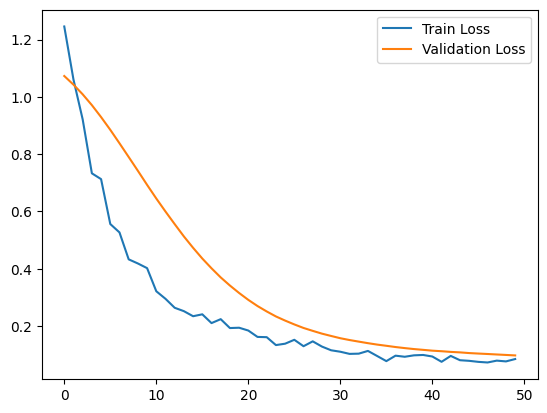

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Завантаження даних
data = load_wine()
X = data.data  # Ознаки
y = data.target  # Мітки (класи)

# Розділення даних на тренувальний, валідаційний та тестовий набори
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42, stratify=y_train_val)

# Стандартизація даних
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Перетворення в тензори
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# 2. Створення моделі
class WineModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(WineModel, self).__init__()
        # Перший прихований шар
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)

        # Другий прихований шар
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)

        # Вихідний шар
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.fc3(x)  # Вихідний шар (логіти)
        return x

# 3. Ініціалізація моделі, оптимізатора та функції втрат
input_size = X_train.shape[1]  # Кількість ознак (13 для Wine)
output_size = len(data.target_names)  # Кількість класів (3 для Wine)

model = WineModel(input_size, output_size)
criterion = nn.CrossEntropyLoss()  # Функція втрат для багатокласової класифікації
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.02)  # L2-регуляризація

# 4. Навчання моделі
train_losses, val_losses = [], []
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Валідація
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")


# 5. Тестування моделі
model.eval()
with torch.no_grad():
    test_output = model(X_test)
    test_loss = criterion(test_output, y_test)
    predictions = torch.argmax(test_output, dim=1)
    accuracy = (predictions == y_test).float().mean()

print(f"Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy.item():.4f}")

# Графік для перевірки перенавчання
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

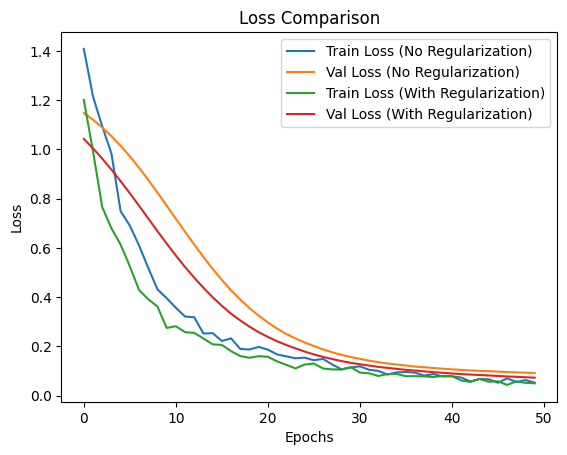

In [30]:
import matplotlib.pyplot as plt

# Змінна для збереження втрат
results = {"no_regularization": {}, "with_regularization": {}}

# 1. Модель без регуляризації
model_no_reg = WineModel(input_size, output_size)
optimizer_no_reg = torch.optim.Adam(model_no_reg.parameters(), lr=0.001)  # Без weight_decay
train_losses_no_reg, val_losses_no_reg = [], []

for epoch in range(epochs):
    model_no_reg.train()
    optimizer_no_reg.zero_grad()
    output = model_no_reg(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer_no_reg.step()
    train_losses_no_reg.append(loss.item())

    model_no_reg.eval()
    with torch.no_grad():
        val_output = model_no_reg(X_val)
        val_loss = criterion(val_output, y_val)
        val_losses_no_reg.append(val_loss.item())


results["no_regularization"]["train"] = train_losses_no_reg
results["no_regularization"]["val"] = val_losses_no_reg

# 2. Модель із регуляризацією
model_with_reg = WineModel(input_size, output_size)
optimizer_with_reg = torch.optim.Adam(model_with_reg.parameters(), lr=0.001, weight_decay=0.01)
train_losses_with_reg, val_losses_with_reg = [], []

for epoch in range(epochs):
    model_with_reg.train()
    optimizer_with_reg.zero_grad()
    output = model_with_reg(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer_with_reg.step()
    train_losses_with_reg.append(loss.item())

    model_with_reg.eval()
    with torch.no_grad():
        val_output = model_with_reg(X_val)
        val_loss = criterion(val_output, y_val)
        val_losses_with_reg.append(val_loss.item())

results["with_regularization"]["train"] = train_losses_with_reg
results["with_regularization"]["val"] = val_losses_with_reg

# 3. Побудова графіків
plt.plot(results["no_regularization"]["train"], label="Train Loss (No Regularization)")
plt.plot(results["no_regularization"]["val"], label="Val Loss (No Regularization)")
plt.plot(results["with_regularization"]["train"], label="Train Loss (With Regularization)")
plt.plot(results["with_regularization"]["val"], label="Val Loss (With Regularization)")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.show()

In [31]:
# 4. Тестування моделі з регуляризацією
model_with_reg.eval()
with torch.no_grad():
    test_output_with_reg = model_with_reg(X_test)
    test_loss_with_reg = criterion(test_output, y_test)
    predictions_with_reg = torch.argmax(test_output, dim=1)
    accuracy_with_reg = (predictions_with_reg == y_test).float().mean()

# 5. Тестування моделі без регуляризації
model_no_reg.eval()
with torch.no_grad():
    test_output_no_reg = model_no_reg(X_test)
    test_loss_no_reg = criterion(test_output, y_test)
    predictions_no_reg = torch.argmax(test_output, dim=1)
    accuracy_no_reg = (predictions_no_reg == y_test).float().mean()

test_accuracy_no_reg = (predictions_no_reg == y_test).float().mean().item()
test_accuracy_with_reg = (predictions_with_reg == y_test).float().mean().item()
print(f"Accuracy without regularization: {test_accuracy_no_reg:.4f}")
print(f"Accuracy with regularization: {test_accuracy_with_reg:.4f}")

Accuracy without regularization: 0.9722
Accuracy with regularization: 0.9722


In [34]:
from sklearn.metrics import classification_report
print("Without Regularization:")
print(classification_report(y_test, predictions_no_reg))
print("With Regularization:")
print(classification_report(y_test, predictions_with_reg))

Without Regularization:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.93      1.00      0.97        14
           2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36

With Regularization:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.93      1.00      0.97        14
           2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



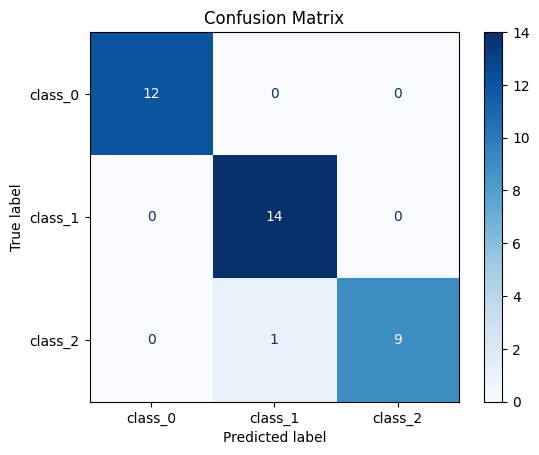

Accuracy: 97.22%
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       0.93      1.00      0.97        14
     class_2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Прогнозування на тестовому наборі
model.eval()
with torch.no_grad():
    test_output = model(X_test)
    predictions = torch.argmax(test_output, dim=1)

# 2. Обчислення матриці невідповідностей
cm = confusion_matrix(y_test, predictions)

# 3. Візуалізація матриці
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

accuracy = (cm.diagonal().sum() / cm.sum()) * 100
print(f"Accuracy: {accuracy:.2f}%")

from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, target_names=data.target_names))